# Capstone Webscrapping using BeautifulSoup

This notebook contains guidances & tasks on the data processing for the application

## Background

Data is everywhere, include from web. But data from web must process before it can be visualize and analytic. This is websrapping from web IMDb, that have information (database) related to films, television series, home videos, video games, and streaming content online – including cast, production crew and personal biographies, plot summaries, trivia, ratings, and fan and critical reviews (wikipedia.com). In here, I will take information from IMDb to get information about top 7 movies. So, it can be recommended for someone, who confuse and ask about "what movies that I can watch?"

## Requesting the Data and Creating a BeautifulSoup

Let's begin with requesting the web from the site with `get` method.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import requests
from requests import get
from bs4 import BeautifulSoup

## Finding the right key to scrap the data & Extracting the right information

As we can see we get a very unstructured and complex html, which actually contains the codes needed to show the webpages on your web browser. But we as human still confused what and where we can use that piece of code, so here where we use the beautifulsoup. Beautiful soup class will result a beautifulsoup object. Beautiful Soup transforms a complex HTML document into a complex tree of Python objects. 

Let's make Beautiful soup object and feel free to explore the object here.

In [31]:
# Creating the lists we want to write into
# define for array 
title = []
rate = []
metascore = []
vot= []

In [32]:
#array for looping data 
#total movie in one layer is 50 movies, 
#for the next page, it must loop (from 1, 51,101, etc)
numb = np.arange(1, 202, 50)
numb

array([  1,  51, 101, 151, 201])

In [33]:
#looping from page 1,51,101,151 and 201
#get data title, rate, metascore and vot from IMDb 

for num in numb:
    #get data from web
    num = requests.get('https://www.imdb.com/search/title/?release_date=2021-01-01,2021-12-31&start=' + str(num) + '&ref_=adv_nxt')
    soup = BeautifulSoup(num.text, 'html.parser')
    
    # get information from all part of movie (include title, vote, etc)
    # in div class lister-item mode-advance
    movie_div = soup.find_all('div', class_='lister-item mode-advanced')
    
    for i in movie_div:
        # Scraping title of movie
        name = i.h3.a.text #get data from h3
        title.append(name) #append data to array title

        # Scraping the rate of movie
        imdb=i.find('div', class_='inline-block ratings-imdb-rating') #get data from div
        if imdb is not None:
            imdb_rating=float(imdb.text) #get data text and change to float type data
        rate.append(imdb_rating) #append data to array rate
        
        # Scraping the metascore
        #get data from span
        #metascore for several movie is empty, so it must define, if empty, just write (-)
        m_score = float(i.find('span', class_='metascore').text) if i.find('span', class_='metascore') else '-' 
        metascore.append(m_score) #append data to array metascore
        
        # Scraping votes 
        vote=i.find('p', class_='sort-num_votes-visible') #get data from p
        if vote is not None:
            votes=vote.text.split()[1]
        vot.append(votes) #append data to array vot

In [34]:
print(len(title),len(rate),len(metascore),len(vot))

250 250 250 250


## Creating data frame & Data wrangling

Put the array into dataframe

In [48]:
#save to DataFrame
movie= pd.DataFrame({'Movie Title':title, 
                       'IMDb_rating':rate, 
                       'Metascore':metascore,
                       'Vote':vot})

movie.head(12)

,Movie Title,IMDb_rating,Metascore,Vote
0,Don't Look Up,7.3,49.0,"312,387"
1,Spider-Man: No Way Home,8.8,71.0,"367,117"
2,The Matrix Resurrections,5.7,63.0,"150,019"
3,Encanto,7.3,76.0,"76,568"
4,The Book of Boba Fett,8.1,-,"16,902"
5,1883,9.1,-,"13,284"
6,The Wheel of Time,7.2,-,"73,390"
7,Hawkeye,7.7,-,"101,530"
8,Dexter: New Blood,8.8,-,"43,630"
9,The King's Man,6.8,44.0,"15,404"


Do the data cleaning here. First, to simplify process data, I will change type data. Then I will make array to get 7 top movies based on web (automation), rate, metascore and vote. 

In [49]:
movie.dtypes

Movie Title     object
IMDb_rating    float64
Metascore       object
Vote            object
dtype: object

In [50]:
#several datatype of metascore is float, and other is str
type(movie['Metascore'][1])

float

In [51]:
movie['Metascore'] = movie['Metascore'].replace('-', np.nan)
movie['Metascore'] = movie['Metascore'].astype(float)

In [52]:
#change dtype of Vote
movie['Vote'] = movie['Vote'].str.replace(',', '') #change , to .
movie['Vote'] = movie['Vote'].astype(float) #change to float

In [53]:
movie.dtypes

Movie Title     object
IMDb_rating    float64
Metascore      float64
Vote           float64
dtype: object

In [54]:
#default 7 top movie
basetop=movie

In [42]:
#get data from not nan metascore and high rate
basetop2 = movie.groupby('Movie Title').agg({
    'Metascore': 'mean',
    'IMDb_rating': 'mean'
}).sort_values(by='Metascore',ascending=False).dropna().sort_values(by='IMDb_rating',ascending=False).reset_index()
basetop2.head(7)

,Movie Title,Metascore,IMDb_rating
0,Spider-Man: No Way Home,71.0,8.8
1,CODA,75.0,8.1
2,Zack Snyder's Justice League,54.0,8.1
3,Verdens verste menneske,88.0,8.1
4,Dune: Part One,74.0,8.1
5,Licorice Pizza,90.0,8.0
6,The Alpinist,67.0,8.0


The more people who vote, the more valid the results. Then data that has more than 150.000 votes will be taken

In [43]:
d=movie['Vote']>150000
movie['Movie Title']=movie['Movie Title'][d]
movie.sort_values('Movie Title',inplace=True)

In [44]:
movie.head(10)

,Movie Title,IMDb_rating,Metascore,Vote
143,Army of the Dead,5.7,57.0,159391.0
53,Black Widow,6.7,67.0,317153.0
77,Cruella,7.4,59.0,203875.0
0,Don't Look Up,7.3,49.0,312387.0
18,Dune: Part One,8.1,74.0,435154.0
46,Free Guy,7.2,62.0,254577.0
126,Godzilla vs. Kong,6.4,59.0,188427.0
114,Jai Bhim,9.4,NaN,165927.0
75,Jungle Cruise,6.6,50.0,161407.0
65,Loki,8.3,NaN,251496.0


In [45]:
#get data from not nan metascore and high rate (vote>150.000)
basetop3 = movie.groupby('Movie Title').agg({
    'Metascore': 'mean',
    'IMDb_rating': 'mean'
}).sort_values(by='Metascore',ascending=False).dropna().sort_values(by='IMDb_rating',ascending=False).reset_index()
basetop3.head(7)

,Movie Title,Metascore,IMDb_rating
0,Spider-Man: No Way Home,71.0,8.8
1,Dune: Part One,74.0,8.1
2,Zack Snyder's Justice League,54.0,8.1
3,Shang-Chi and the Legend of the Ten Rings,71.0,7.5
4,Nobody,64.0,7.4
5,Cruella,59.0,7.4
6,No Time to Die,68.0,7.4


Data visualisation (please change this markdown with your explanation of what you do for data wrangling)

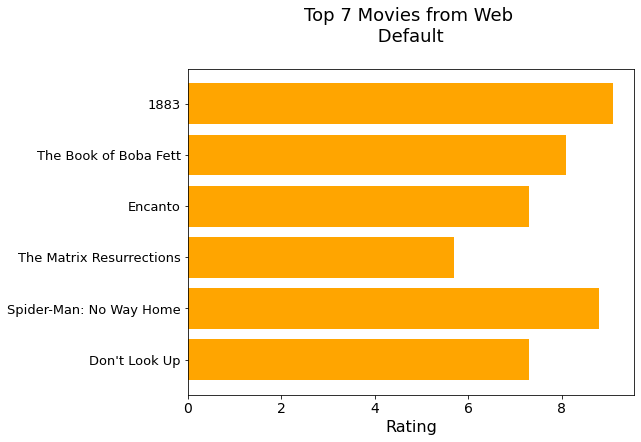

In [66]:
fig = plt.figure(figsize=(8,6))
#ax = fig.add_axes([0,0,1,1])
title_ = basetop['Movie Title'][0:6]
rate_ = basetop['IMDb_rating'][0:6]
plt.barh(title_,rate_,color='orange')
plt.xticks(fontsize=14)
plt.yticks(fontsize=13)
plt.xlabel(r'Rating',fontsize=16)
plt.title('Top 7 Movies from Web \n Default \n',fontsize=18)
plt.show()

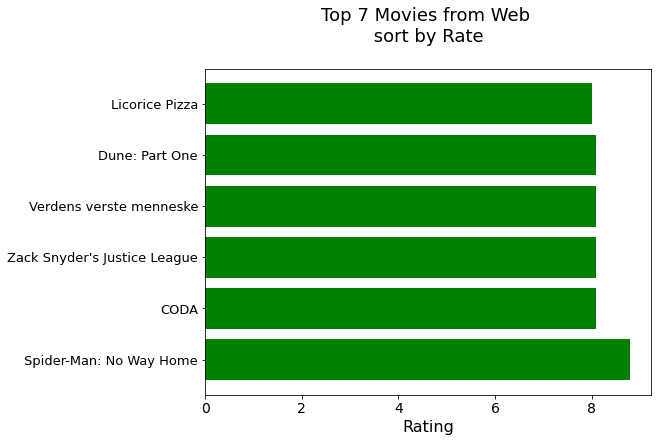

In [71]:
fig = plt.figure(figsize=(8,6))
#ax = fig.add_axes([0,0,1,1])
title_ = basetop2['Movie Title'][0:6]
rate_ = basetop2['IMDb_rating'][0:6]
plt.barh(title_,rate_,color='g')
plt.xticks(fontsize=14)
plt.yticks(fontsize=13)
plt.xlabel(r'Rating',fontsize=16)
plt.title('Top 7 Movies from Web \n sort by Rate \n',fontsize=18)
plt.show()

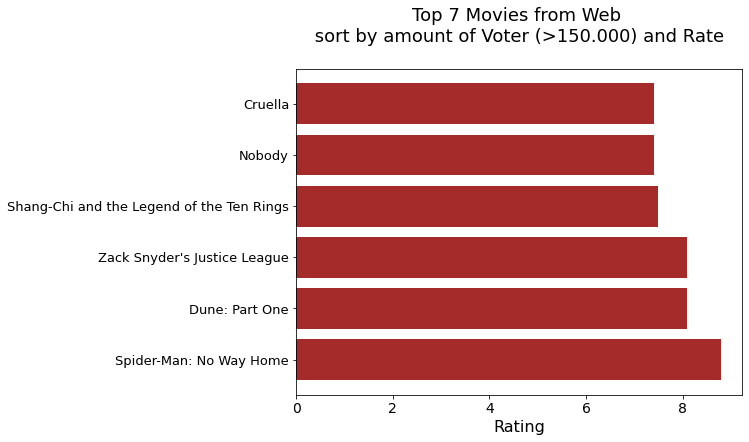

In [72]:
fig = plt.figure(figsize=(8,6))
#ax = fig.add_axes([0,0,1,1])
title_ = basetop3['Movie Title'][0:6]
rate_ = basetop3['IMDb_rating'][0:6]
plt.barh(title_,rate_,color='brown')
plt.xticks(fontsize=14)
plt.yticks(fontsize=13)
plt.xlabel(r'Rating',fontsize=16)
plt.title('Top 7 Movies from Web \n sort by amount of Voter (>150.000) and Rate \n',fontsize=18)
plt.show()

### Implementing your webscrapping to the flask dashboard

- Copy paste all of your web scrapping process to the desired position on the `app.py`
- Changing the title of the dasboard at `index.html`

## Finishing This Notebook with Your Analysis and Conclusion

First you can do start with making the data visualisation. 

From 3 pictures above, we know top 7 movies from IMDb. First picture, it is default suggest popular movies from IMDb, I think it is based on several aspect. Then, second picture, 7 top movies based on rate. And the last picture, it is based on amount of vote (>150.000) and rate. 

So, if someone wants to see a movie, the top 7 from 3 picture above can be a reference. And from those picture, I can say that watching **Spiderman:No Way Home** will be a best chance for now.

### Extra Challange

This will be not included to the scoring. 

- You can create additional analysis from the data.
- Implement it to the dashboard with at `app.py` dan `index.html`.